## Prerequisites

In [ ]:
!pip install -r requirements.txt

In [1]:
import torch
import transformers
assert torch.cuda.is_available()

## Read data

In [2]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import model_selection

DATADIR = Path('./data')
WORKDIR = Path('./work')

In [3]:
context_json = json.load(open(DATADIR / 'context.json'))  # list of strings
train_json = json.load(open(DATADIR / 'train.json'))
valid_json = json.load(open(DATADIR / 'valid.json'))

len(context_json), len(train_json), len(valid_json)

(9013, 21714, 3009)

context length med: 405.0 top: [1186, 1189, 1236, 1242, 1248, 1331, 1349, 1352, 1428, 1765]
answer start med: 147.0 top: [980, 1016, 1026, 1035, 1071, 1083, 1104, 1145, 1236, 1254]


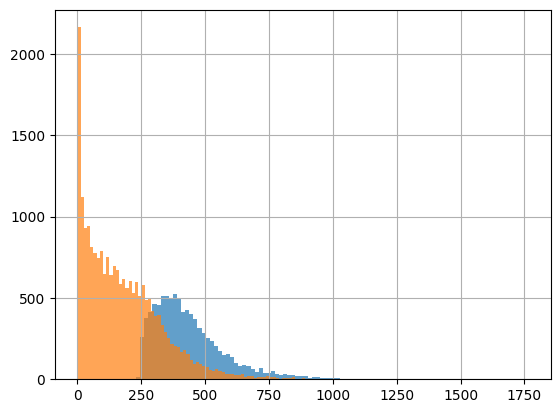

In [4]:
# context lengths and answer start distribution

lens = pd.Series(len(s) for s in context_json)
print('context length med:', lens.median(), 'top:', sorted(lens)[-10:])
lens.hist(bins=100, alpha=.7);

st = pd.Series(ex['answer']['start'] for ex in train_json)
print('answer start med:', st.median(), 'top:', sorted(st)[-10:])
st.hist(bins=100, alpha=.7);

answer len med: 4.0 top: [38, 38, 40, 41, 41, 41, 42, 45, 49, 50, 52, 52, 60, 78, 118]


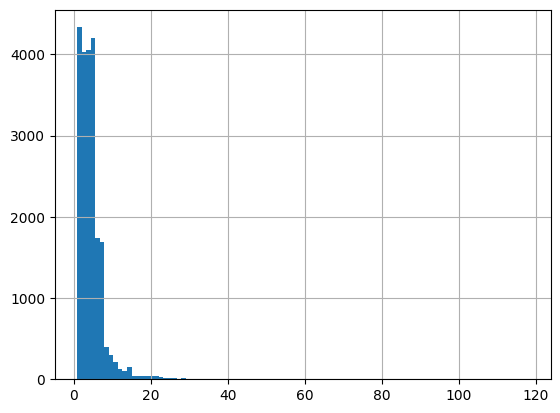

In [5]:
# answer lengths distribution
lens = pd.Series(len(ex['answer']['text']) for ex in train_json)
print('answer len med:', lens.median(), 'top:', sorted(lens)[-15:])
lens.hist(bins=100);

`--answer_length=40` (up from default 30) should be a reasonable setting.

## Convert dataset to SWAG format for context selection subtask

Reference: https://huggingface.co/datasets/swag#data-instances


In [9]:
def convert_example_to_swag(example, contexts):
    conv = {
        'sent1': example['question'],
        'sent2': '',  # will be merely prepended to each ending so can be empty
        'ending0': contexts[example['paragraphs'][0]],
        'ending1': contexts[example['paragraphs'][1]],
        'ending2': contexts[example['paragraphs'][2]],
        'ending3': contexts[example['paragraphs'][3]],
    }
    if 'relevant' in example:
        conv['label'] = example['paragraphs'].index(example['relevant'])
    return conv

# Test on one example
train_json[0], '-'*100,\
convert_example_to_swag(train_json[0], context_json)

({'id': '593f14f960d971e294af884f0194b3a7',
  'question': '舍本和誰的數據能推算出連星的恆星的質量？',
  'paragraphs': [2018, 6952, 8264, 836],
  'relevant': 836,
  'answer': {'text': '斯特魯維', 'start': 108}},
 '----------------------------------------------------------------------------------------------------',
 {'sent1': '舍本和誰的數據能推算出連星的恆星的質量？',
  'sent2': '',
  'ending0': '1930年，印度物理學家蘇布拉馬尼揚·錢德拉塞卡根據廣義相對論計算出質量大於1.4倍太陽質量的非轉動星體會因重力塌縮成為電子簡併態。愛丁頓雖然在理論上支持黑洞存在的可能性，但同時認為錢德拉塞卡的觀點事實上不能成立，他認為「應當有某種自然定律阻止恆星出現這種荒唐的行為」。當時的物理學家如波耳、亨利·羅素等人都贊同錢德拉塞卡的理論，但出於愛丁頓聲望的原因，他們並沒有公開對錢德拉塞卡表示支持。不過從某種意義上說，愛丁頓也是正確的，當恆星質量大於錢德拉塞卡極限後，確實仍然會有中子簡併壓力阻止恆星繼續塌縮。到了1939年，美國物理學家羅伯特·歐本海默等人推算了這種情形的恆星質量上限，這個極限被稱作托爾曼-歐本海默-沃爾科夫極限。當今的天體物理學家普遍認為，除非有如未知的夸克簡併壓力一類因素的存在，質量大於托爾曼-歐本海默-沃爾科夫極限的恆星將最終會塌縮為錢德拉塞卡所預言的黑洞。即使如此，史瓦西解作為當時能夠描述黑洞行為的唯一精確解，由於具有一些讓人看似不大優美的性質以及難以與實驗觀測相聯繫，一直沒有進入主流物理學研究的視野，關於黑洞的理論乃至整個廣義相對論領域的研究由此擱置了二十年之久。',
  'ending1': '心理學是否為自然科學的範圍，目前也尚存爭議，一般較廣為接受的說法是心理學同時包含在自然科學與社會科學的範疇之中。自然科學的根本目的在於尋找隱藏在自然現象背後的規律，但是自然科學的工作尚不包括研究為什麼會存在這些規律。自然科學認為超自然的、隨意的和自相矛盾的現象是

In [10]:
def convert_dataset_to_swag(examples, contexts, path):
    conv = [convert_example_to_swag(ex, contexts) for ex in examples]
    path = Path(path).absolute()
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as fp:
        json.dump(conv, fp, indent=2, ensure_ascii=False)

convert_dataset_to_swag(train_json, context_json, WORKDIR / 'train_swag.json')
convert_dataset_to_swag(valid_json, context_json, WORKDIR / 'valid_swag.json')

In [9]:
Path(WORKDIR / 'train_swag.json').absolute()

PosixPath('/home/guest/r11922a05/ADL/ADL21-HW2/work/train_swag.json')

## Convert dataset to SQUAD format for QA subtask

Ref: https://huggingface.co/datasets/squad_v2

In [4]:
def convert_example_to_squad(example, contexts):
    assert contexts[example['relevant']][example['answer']['start']:].startswith(example['answer']['text'])
    return {
        'id': example['id'],
        'title': example['id'],
        'context': contexts[example['relevant']],
        'question': example['question'],
        'answers': {
            'text': [example['answer']['text']],
            'answer_start': [example['answer']['start']],
        },
    }

# Test on one example
train_json[0], '-'*100,\
convert_example_to_squad(train_json[0], context_json)

({'id': '593f14f960d971e294af884f0194b3a7',
  'question': '舍本和誰的數據能推算出連星的恆星的質量？',
  'paragraphs': [2018, 6952, 8264, 836],
  'relevant': 836,
  'answer': {'text': '斯特魯維', 'start': 108}},
 '----------------------------------------------------------------------------------------------------',
 {'id': '593f14f960d971e294af884f0194b3a7',
  'title': '593f14f960d971e294af884f0194b3a7',
  'context': '在19世紀雙星觀測所獲得的成就使重要性也增加了。在1834年，白塞爾觀測到天狼星自行的變化，因而推測有一顆隱藏的伴星；愛德華·皮克林在1899年觀測開陽週期性分裂的光譜線時發現第一顆光譜雙星，週期是104天。天文學家斯特魯維和舍本·衛斯里·伯納姆仔細的觀察和收集了許多聯星的資料，使得可以從被確定的軌道要素推算出恆星的質量。第一個獲得解答的是1827年由菲利克斯·薩瓦里透過望遠鏡的觀測得到的聯星軌道。對恆星的科學研究在20世紀獲得快速的進展，相片成為天文學上很有價值的工具。卡爾·史瓦西發現經由比較視星等和攝影星等的差別，可以得到恆星的顏色和它的溫度。1921年，光電光度計的發展可以在不同的波長間隔上非常精密的測量星等。阿爾伯特·邁克生在虎克望遠鏡第一次使用干涉儀測量出恆星的直徑。',
  'question': '舍本和誰的數據能推算出連星的恆星的質量？',
  'answers': {'text': ['斯特魯維'], 'answer_start': [108]}})

In [5]:
def convert_dataset_to_squad(examples, contexts, path):
    conv = [convert_example_to_squad(ex, contexts) for ex in examples]
    conv = {'data': conv}
    path = Path(path).absolute()
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as fp:
        json.dump(conv, fp, indent=2, ensure_ascii=False)

convert_dataset_to_squad(train_json, context_json, WORKDIR / 'train_squad.json')
convert_dataset_to_squad(valid_json, context_json, WORKDIR / 'valid_squad.json')

## Baseline model training

Context selection:

```sh
python run_swag_no_trainer.py \
  --model_name_or_path=bert-base-chinese \
  --train_file=work/train_swag.json \
  --validation_file=work/valid_swag.json \
  --max_length=384 \
  --per_device_train_batch_size=1 \
  --gradient_accumulation_steps=2 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --checkpointing_steps=1000 \
  --output_dir=work/baseline-swag-run1
```

* 1h on GTX 1080
* Validation accuracy 0.9335

Question answering:

```sh
python run_qa_no_trainer.py \
  --model_name_or_path=bert-base-chinese \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=384 \
  --per_device_train_batch_size=1 \
  --gradient_accumulation_steps=2 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --checkpointing_steps=1000 \
  --output_dir work/baseline-qa-run1
```
* 37 min on GTX 1080
* Validation: exact_match 78.4314
* Final score estimate: 0.9335*78.4314 = <font color=purple>**73.22**</font> - close enough to reported 'Simple Baseline' 0.73508

## Experiments

### QA small experiments and trad/simplified initialization

Original inputs are traditional but most pre-trained models seem biased towards simplified writing.
Convert to simplified for experimentation:

In [11]:
import opencc

def deep_t2s(obj, conv):
    if type(obj) is str:
        res = conv.convert(obj)
        assert len(res) == len(obj)
        return res
    elif type(obj) is list:
        return [deep_t2s(x, conv) for x in obj]
    elif type(obj) is dict:
        return {k: deep_t2s(v, conv) for (k, v) in obj.items()}
    else:
        return obj

# tw2sp changes lengths/offsets, not good
for c in ['t2s', 'tw2s']:
    train_s_json = deep_t2s(train_json, opencc.OpenCC(c))
    valid_s_json = deep_t2s(valid_json, opencc.OpenCC(c))
    context_s_json = deep_t2s(context_json, opencc.OpenCC(c))

    convert_dataset_to_swag(train_s_json, context_s_json, WORKDIR / f'train_swag_{c}.json')
    convert_dataset_to_swag(valid_s_json, context_s_json, WORKDIR / f'valid_swag_{c}.json')
    convert_dataset_to_squad(train_s_json, context_s_json, WORKDIR / f'train_squad_{c}.json')
    convert_dataset_to_squad(valid_s_json, context_s_json, WORKDIR / f'valid_squad_{c}.json')

```sh
python run_qa_no_trainer.py \
  --model_name_or_path=bert-base-chinese \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=8 \
  --gradient_accumulation_steps=2 \
  --learning_rate=5e-5 \
  --num_train_epochs=1 \
  --max_train_samples=1000 \
  --max_eval_samples=1000 \
  --max_answer_length=40 \
  --seed=42 \
  --output_dir work/qa-test

                             exact match
bert-base-chinese            26.4; t2s 27.5; tw2s 27.2
hfl/chinese-bert-wwm         31.1; t2s 31.9; tw2s 31.7
hfl/chinese-bert-wwm-ext     32.6; t2s 28.8 seed=111: 34.3; tw2s 31.1 seed=222 35.1;  t2s lr=3e-4 16.0, lr=3e-5 27.0
hfl/chinese-roberta-wwm-ext  41.7; t2s 42.1; tw2s 42.5 seed=111 bs=8: 47.3 lr=3e-4: 41.8
hfl/chinese-macbert-base     43.9 lr=3e-4 48.6; seed=111 bs=8: 47.5; bs=8: 40.5
                         t2s 42.5 lr=3e-4 43.6; seed=111 bs=8: 48.1
                        tw2s 42.9 lr=3e-4 46.8; seed=111 bs=8: 48.2
IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese
                             33.1
                         t2s 47.3 lr=3e-4: diverged, bs=8: 48.7
                        tw2s 45.8 seed=111 bs=8: 47.1 lr=1e-5: 22.3
random seeds:
hfl/chinese-electra-180g-base-discriminator  t2s 15.0
hfl/rbt6                           t2s 26.4
ckiplab/bert-base-chinese    23.3, t2s 23.6
microsoft/deberta-v3-base    26.2, t2s 29.0 31.8, tw2s 26.0  bs=8 lr=3e-4: 6.4 lr=1e-5:8.5
```

* `roberta-wwm-ext`, `macbert-base`, `deberta` seem like the strongest pre-trained models based on these quick tests
* `deberta-v3` is favorite in recent kaggle competitions, but there's only a generic multilingual available for it which performs less well than specialized chinese trained models
* For many models, simplified input seems better - I guess due to the way they were trained, more data available in simplified, researchers bias etc.
* Effect is particularly high for Erlangshen-DeBERTa and seems to be due to bias in vocabulary: ~100 traditional characters selected into vocab vs. thousands in other models. So need to fix up both embedding matrix and tokenizer vocab.

Implemented --init-trad option to initialize embeddings for trad tokens from simplified, adding new tokens to tokenizer/embedding if necessary. Test:

```sh
python run_qa_no_trainer.py \
  --model_name_or_path=IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=8 \
  --gradient_accumulation_steps=2 \
  --learning_rate=5e-5 \
  --num_train_epochs=1 \
  --max_train_samples=1000 \
  --max_eval_samples=1000 \
  --max_answer_length=40 \
  --seed=42 \
  --output_dir work/qa-test
  [+/- --init-trad]

```
* IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese: 32.7 -> --init-trad: 46.1
* bert-base-chinese: 26.4, --init-trad: 29.1
* hfl/chinese-bert-wwm-ext: 32.6, --init-trad: 39.0
* doesn't help:
  * hfl/chinese-roberta-wwm-ext: 41.7, --init-trad: 41.3
  * hfl/chinese-macbert-base: 43.9, --init-trad: 41.8

#### SWAG

```sh
python run_swag_no_trainer.py \
  --model_name_or_path=hfl/chinese-roberta-wwm-ext \
  --train_file=work/train_swag.json \
  --validation_file=work/valid_swag.json \
  --max_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=8 \
  --learning_rate=3e-4 \
  --num_train_epochs=1 \
  --max_train_samples=1000 \
  --max_eval_samples=1000 \
  --seed=42 \
  --output_dir=work/swag-test

                            accuracy
bert-base-chinese           0.935, --init-trad 0.924
IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese  --init-trad 0.95
hfl/chinese-bert-wwm-ext    --init-trad 0.931, lr=1e-5 0.922
hfl/chinese-macbert-base    0.953
hfl/chinese-roberta-wwm-ext 0.737
```

When running training for more steps, in general accuracy seems to plateau around 96%. For 3-4% of the input the answer does not lie in the first 512 characters, so that's probably the limiting factor:

In [23]:
sum([ex['answer']['start'] > 512 for ex in train_json])/len(train_json),\
sum([ex['answer']['start'] > 512 for ex in valid_json])/len(valid_json)

(0.03186884037947868, 0.036889332003988036)

Hard to fix via modelling as most pre-trained models limited to 512 sequence length. 

Proposal: fix this up in evaluation - run context selection model a second time from some offset and pick the higher score between two runs.

### QA with concatenation/sum of last n layers in the prediction head

```sh
python run_qa_no_trainer.py \
  --model_name_or_path=IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese \
  --cat-n=3 --cat-op=cat --init-trad \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --max_train_samples=1000 \
  --max_eval_samples=1000 \
  --max_answer_length=40 \
  --seed=42 \
  --output_dir work/qa-test

IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese --init-trad 43.2, bs=8 48.8
  --init-trad cat2 bs=2 48.9  51.3
  --init-trad sum2 bs=2 
  
hfl/chinese-roberta-wwm-ext 44.2
bert-base-chinese --init-trad 25.7
hfl/chinese-macbert-base
  --init-trad --seed=111 bs=8: 43.4, +lr=3e-4: 44.0;
  --seed=111 bs=2 lr=3e-5: 49.8, --head-type=auto: 50.8, --init-trad: 48.4
  --seed=111 bs=2 lr=1e-5: 38.7  lr=3e-4: diverged

python run_qa_no_trainer.py \
  --model_name_or_path=IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese \
  --cat-n=2 --init-trad \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --checkpointing_steps=256 \
  --max_eval_samples=1000 \
  --max_answer_length=40 \
  --seed=42 \
  --weight_decay=0.01 \
  --lr_scheduler_type=cosine \
  --output_dir work/qa-test
  
      exact match at each cheakpoint:
auto  46.1 50.8 51.5 53.4 52.5 52.7 54.0 55.1
cat4  47.9 50.0 53.0 56.2 53.9 55.7 54.4 55.4
sum4  48.5 50.0 54.2 47.7 54.7 52.7 55.4 55.0
sum2  48.6 51.6 53.4 49.9 54.6 55.0 55.6 57.3
cat2  48.5 52.5 52.3 52.5 54.4 56.3 55.9 55.1
```

## Ensemble

swag: single model
```sh
python run_swag_no_trainer.py \
  --model_name_or_path=hfl/chinese-bert-wwm-ext \
  --init-trad \
  --train_file=work/train_swag.json \
  --validation_file=work/valid_swag.json \
  --max_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=8 \
  --weight_decay=0.01 \
  --learning_rate=1e-5 \
  --lr_scheduler_type=cosine \
  --num_train_epochs=1 \
  --checkpointing_steps=128 \
  --max_eval_samples=3000 \
  --seed=42 \
  --output_dir=work/swag1
accuracy 0.9688 (with second eval @384; one eval 0.9558)
```

qa: ensemble 3 different 12-layer pretrained models
    
```sh
python run_qa_no_trainer.py \
  --model_name_or_path=IDEA-CCNL/Erlangshen-DeBERTa-v2-97M-Chinese \
  --cat-n=2 --cat-op=sum --init-trad \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --checkpointing_steps=2048 \
  --max_answer_length=40 \
  --seed=123 \
  --weight_decay=0.01 \
  --lr_scheduler_type=cosine \
  --output_dir work/qa1
81.78796942505817

python run_qa_no_trainer.py \
  --model_name_or_path=hfl/chinese-roberta-wwm-ext \
  --cat-n=2 --cat-op=cat \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --checkpointing_steps=2048 \
  --seed=456 \
  --weight_decay=0.01 \
  --lr_scheduler_type=cosine \
  --output_dir=work/qa2
80.82419408441342

python run_qa_no_trainer.py \
  --model_name_or_path=hfl/chinese-macbert-base \
  --cat-n=2 --cat-op=sum \
  --train_file=work/train_squad.json \
  --validation_file=work/valid_squad.json \
  --max_seq_length=512 \
  --per_device_train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=3e-5 \
  --num_train_epochs=1 \
  --checkpointing_steps=2048 \
  --seed=567 \
  --weight_decay=0.01 \
  --lr_scheduler_type=cosine \
  --output_dir=work/qa3
81.78796942505817
```

Evaluate ensemble end-to-end:
```sh
./eval.py \
  -i data/valid.json \
  -c data/context.json \
  -S work/swag1 -Q work/qa1 -Q work/qa2 -Q work/qa3 \
  -o work/output.csv
  
work/swag1: context selection accuracy 0.9688 (with second eval @384; one eval 0.9558)
work/qa1: exact match 79.9269 (2405/3009 correct)
work/qa2: exact match 78.9299 (2375/3009 correct)
work/qa3: exact match 79.8604 (2403/3009 correct)
ensemble: exact match 81.4224 (2450/3009 correct)
```

**<font color=purple>81.4224</font>** on valid.json

# Mytest

```sh
work/swag1: context selection accuracy 0.9648 (with second eval @384; one eval 0.9555)
work/qa1: exact match 72.9478 (2195/3009 correct)
work/qa2: exact match 78.3317 (2357/3009 correct)
work/qa3: exact match 79.1293 (2381/3009 correct)
ensemble: exact match 79.7940 (2401/3009 correct)
```

```sh
work/swag1: context selection accuracy 0.9648 (with second eval @384; one eval 0.9555)
work/qa2: exact match 78.3317 (2357/3009 correct)
work/qa3: exact match 79.1293 (2381/3009 correct)
ensemble: exact match 79.6278 (2396/3009 correct)
```